# A review on (Bayesian) regression techniques

__Objective:__ apply different (Bayesian) techniques to a regression problem to get a feel for how they work.

Source: [here](https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb).

In [555]:
from math import pi
import sys
import pickle
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../modules/')

from keras_utilities import NEpochsLogger, append_to_full_history, plot_history
from tfp_utilities import plot_prediction_distr, nll, get_divergence_fn, generate_predictions

tfd = tfp.distributions

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate data

We generate data divided into 3 consecutive regions, with the first and the last being exactly linear (datapoints lie on a straight line). In the second regions points are distributed according to a Gaussian centered on the sum of a sine and a linear function, with standard eviation **depending on the amplitude of $\sin$: this create heteroskedasticity: the standard deviation of the data is bigger at the max and min points of the sinusoid.

In [2]:
def generate_data(n_samples_sine=300, n_samples_linear=60):
    """
    Generates synthetic data with x in [-3, 3], divided in 3
    consecutive regions:
        1. A linear part.
        2. A linear part added to a sine part with Gaussian noise
           with standar deviation proportional to the absolute value
           of the value of the sine part alone.
        3. Another linear part.
    """
    n_samples_sine = 156
    n_samples_linear = 60
    
    x_sin_min = 0.
    x_sin_max = 6. * tf.constant(pi)
    x_min = x_sin_min - 3.
    x_max = x_sin_max + 3.
    
    x = tf.concat(
        [
            tf.linspace(x_min, x_sin_min, n_samples_linear),
            tf.linspace(x_sin_min, x_sin_max, n_samples_sine),
            tf.linspace(x_sin_max, x_max, n_samples_linear)
        ],
        axis=0
    )
    
    
    
    x_sin = tf.linspace(0., 2. * tf.constant(pi), n_samples_sine)
    y_sin = 3. * tf.math.sin(x_sin) + tf.squeeze(tfd.Normal(loc=tf.zeros_like(x_sin),scale=0.15 * tf.abs(3. * tf.math.sin(x_sin))).sample())
    
    y = tf.concat(
        [
            tf.zeros(shape=(n_samples_linear,)),
            y_sin,
            tf.zeros(shape=(n_samples_linear,))
        ],
        axis=0
    ) + 0.1 * x + 1.

    return x[..., tf.newaxis], y

Text(0.5, 1.0, 'Synthetic data')

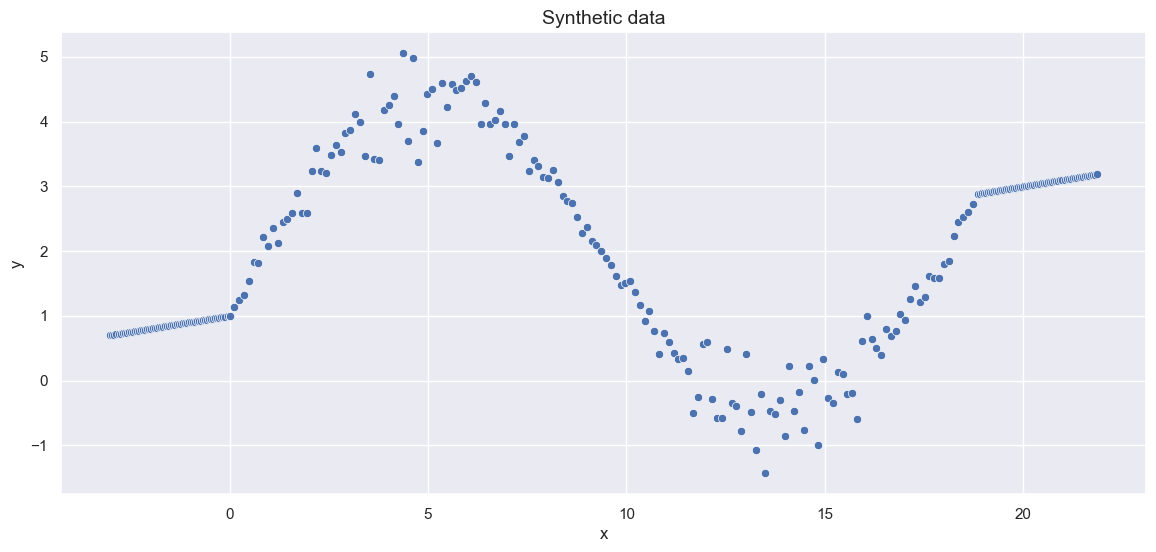

In [3]:
x, y = generate_data()

fig = plt.figure(figsize=(14, 6))

sns.scatterplot(
    x=x[:, 0],
    y=y
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic data', fontsize=14)

## Model: NN with final probabilistic layer

A NN with non-Bayesian hidden layer but with a final probabilistic layer is able to capture the aleatoric uncertainty in the data, but not the epistemic one. In this case, the output probabilistic layer generates Gaussian distributions with both their means and their standard deviations parametrized by the neural network. If the NN is sufficiently flexible, we should be able to model heteroskedasticity this way (i.e. the fact that the aleatoric uncertainty - the standard deviation of the data-generating distribution - depends on the regressor $x$ itself).

In [30]:
model_probabilistic = tf.keras.Sequential([
    BatchNormalization(),
    Dense(units=40, activation='relu'),
    Dense(units=20, activation='relu'),
    Dense(units=40, activation=None),
    Dense(units=2),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], scale=tf.math.softplus(t[..., 1:]))
    )
])

history_probabilistic_full = {}

In [39]:
learning_rate = 1e-3

optimizer_probabilistic = tf.keras.optimizers.Adam(learning_rate=learning_rate) # tf.keras.optimizers.SGD(learning_rate=learning_rate)


model_probabilistic.compile(
    optimizer=optimizer_probabilistic,
    loss=nll,
    metrics=['mse'],
)

model_probabilistic(x[:1, ...])

model_probabilistic.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 1)                 4         
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 40)                80        
                                                                 
 dense_13 (Dense)            (None, 20)                820       
                                                                 
 dense_14 (Dense)            (None, 40)                840       
                                                                 
 dense_15 (Dense)            (None, 2)                 82        
                                                                 
 distribution_lambda_4 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))              

In [45]:
# To change the value of the learning rate after training for a set
# number of epochs.
K.set_value(model_probabilistic.optimizer.learning_rate, 1e-5)

Epoch: 0 - loss: 0.5180506110191345 - mse: 0.8580998182296753
Epoch: 100 - loss: 0.5119504332542419 - mse: 0.6342328190803528
Epoch: 200 - loss: 0.5890093445777893 - mse: 0.6360054612159729
Epoch: 300 - loss: 0.5280338525772095 - mse: 0.641531765460968
Epoch: 400 - loss: 0.8266735076904297 - mse: 1.0342539548873901
Epoch: 500 - loss: 0.8762295246124268 - mse: 0.7162697911262512
Epoch: 600 - loss: 0.5617113709449768 - mse: 0.7002730369567871
Epoch: 700 - loss: 0.46217408776283264 - mse: 0.5659206509590149
Epoch: 800 - loss: 0.5689042806625366 - mse: 0.6937374472618103
Epoch: 900 - loss: 0.49825817346572876 - mse: 0.5920616984367371
Epoch: 1000 - loss: 0.47325703501701355 - mse: 0.6437975168228149
Epoch: 1100 - loss: 0.5028234720230103 - mse: 0.624653697013855
Epoch: 1200 - loss: 0.45527616143226624 - mse: 0.48404526710510254
Epoch: 1300 - loss: 0.5240896344184875 - mse: 0.5522061586380005
Epoch: 1400 - loss: 0.7981889843940735 - mse: 0.84066241979599
Epoch: 1500 - loss: 0.50881022214889

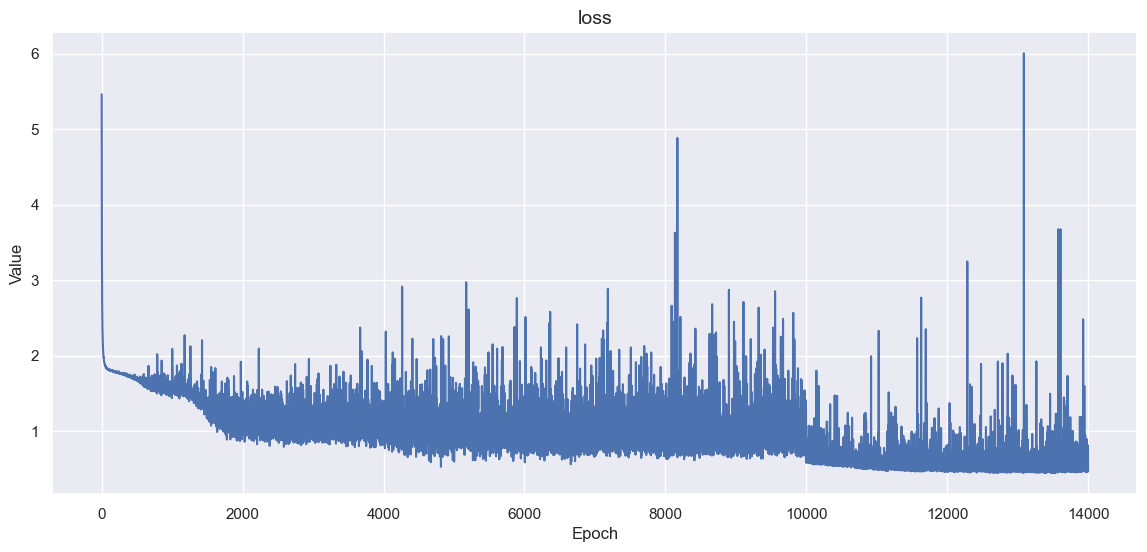

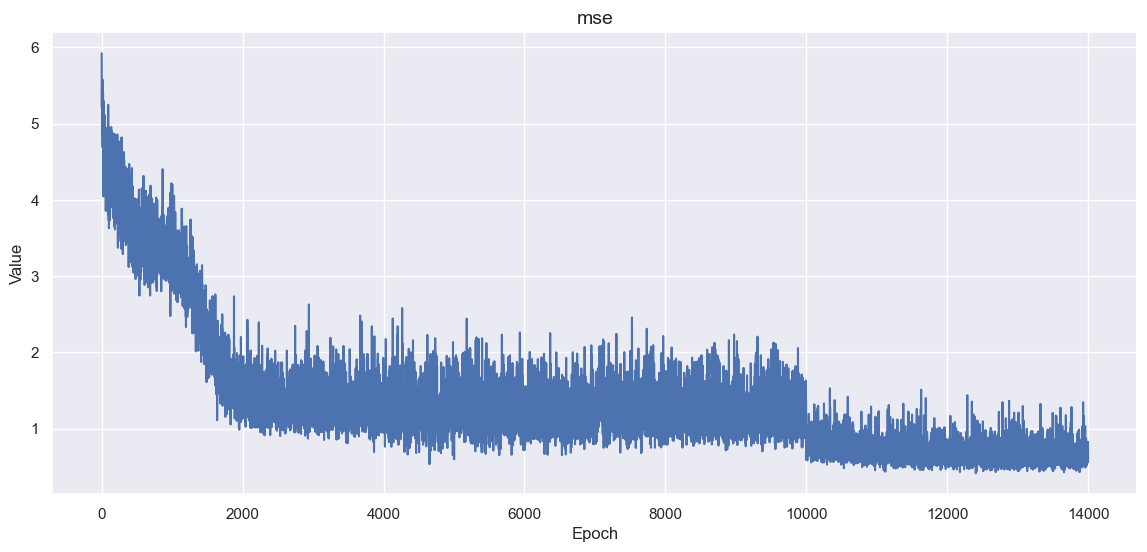

In [50]:
epochs = 2000

history_probabilistic = model_probabilistic.fit(
    x=x,
    y=y,
    epochs=epochs,
    verbose=0,
    callbacks=[NEpochsLogger(100)],
    batch_size=128
)

history_probabilistic_full = append_to_full_history(history_probabilistic, history_probabilistic_full)

plot_history(history_probabilistic_full)

Observations: once trained, a sufficiently flexible model exhibits the following features,
- The estimated aleatoric uncertainty is bigger in the central sinusoidal region (where dataponts are more spread), while in the initial and final regions (exact straight lines) the estimate is small.
- Extrapolation beyond the region where the data lies just carries on the linear trend with the corresponding small aleatoric uncertainty. This is **not desirable** as we'd like the model to be very uncertain when extrapolating to regions in which it's seen no data at all (the estimate of epistemic uncertainty is needed to do this).

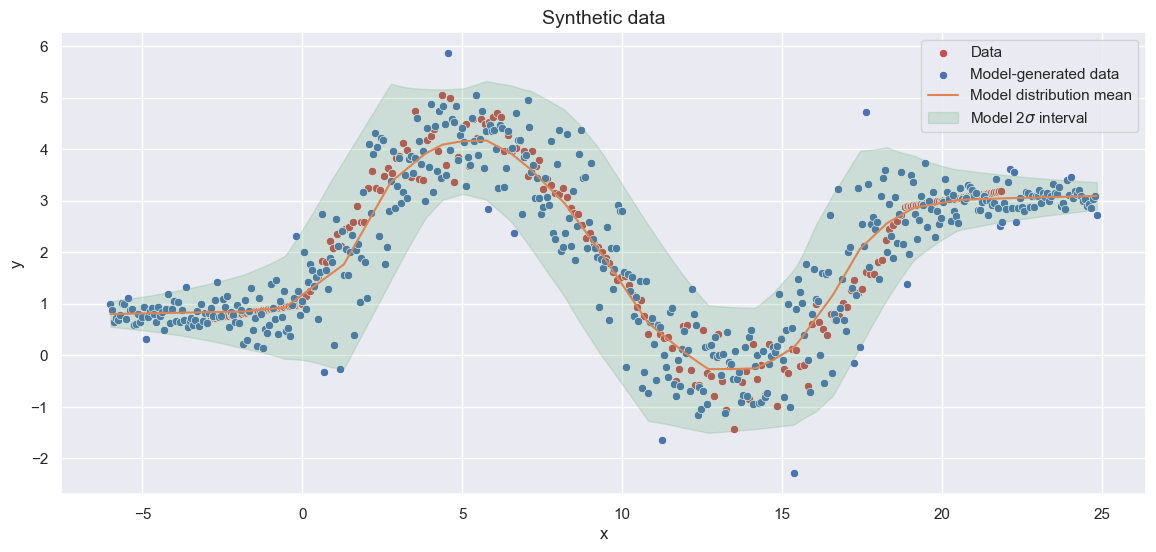

In [51]:
plot_prediction_distr(
    x,
    y,
    model_probabilistic,
    x_plot_min=x.numpy().min() - 3.,
    x_plot_max=x.numpy().max() + 3.
)

In [346]:
# model_probabilistic.save('../models/regression_review_probabilistic_model.tf')

# with open('../models/regression_review_probabilistic_model_history.pkl', 'wb') as f:
#     pickle.dump(history_bayesian_vi_full, f)

## Model: Bayesian NN with VI

In [598]:
divergence_fn = get_divergence_fn(norm_factor=5. * x.shape[0])

In [609]:
model_bayesian_vi = tf.keras.Sequential([
    BatchNormalization(),
    tfp.layers.DenseLocalReparameterization(units=40, activation='relu', kernel_divergence_fn=divergence_fn),
    tfp.layers.DenseLocalReparameterization(units=40, activation='relu', kernel_divergence_fn=divergence_fn),
    tfp.layers.DenseLocalReparameterization(units=20, activation=None, kernel_divergence_fn=divergence_fn),
    tfp.layers.DenseLocalReparameterization(units=2, kernel_divergence_fn=divergence_fn),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :1], scale=tf.math.softplus(t[..., 1:])),
            reinterpreted_batch_ndims=1
        )
    )
])

history_bayesian_vi_full = {}

In [610]:
learning_rate = 1e-4

optimizer_bayesian_vi = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_bayesian_vi.compile(
    optimizer=optimizer_bayesian_vi,
    loss=nll,
    metrics=['mse']
)

model_bayesian_vi(x)

model_bayesian_vi.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_20 (Ba  (276, 1)                  4         
 tchNormalization)                                               
                                                                 
 dense_local_reparameteriza  (276, 40)                 120       
 tion_56 (DenseLocalReparam                                      
 eterization)                                                    
                                                                 
 dense_local_reparameteriza  (276, 40)                 3240      
 tion_57 (DenseLocalReparam                                      
 eterization)                                                    
                                                                 
 dense_local_reparameteriza  (276, 20)                 1620      
 tion_58 (DenseLocalReparam                          

In [611]:
# To change the value of the learning rate after training for a set
# number of epochs.
# K.set_value(model_bayesian_vi.optimizer.learning_rate, 1e-6)

In [612]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000, 4000, 5000],
    values=[1e-4, 1e-5, 1e-6, 1e-7]
)

Epoch: 0 - loss: 13.316551208496094 - mse: 6.688870429992676
Epoch: 50 - loss: 6.935159206390381 - mse: 4.724695205688477
Epoch: 100 - loss: 6.271034240722656 - mse: 4.997439384460449
Epoch: 150 - loss: 6.141671180725098 - mse: 4.411331653594971
Epoch: 200 - loss: 6.004269123077393 - mse: 3.8595404624938965
Epoch: 250 - loss: 5.8816070556640625 - mse: 3.55352783203125
Epoch: 300 - loss: 5.71926212310791 - mse: 3.5395760536193848
Epoch: 350 - loss: 5.680653095245361 - mse: 3.489502429962158
Epoch: 400 - loss: 5.483696460723877 - mse: 2.7980401515960693
Epoch: 450 - loss: 5.430731296539307 - mse: 2.83132004737854
Epoch: 500 - loss: 5.37998628616333 - mse: 2.8785903453826904
Epoch: 550 - loss: 5.303219318389893 - mse: 2.8297817707061768
Epoch: 600 - loss: 5.142613410949707 - mse: 2.5173580646514893
Epoch: 650 - loss: 5.134128570556641 - mse: 2.640357255935669
Epoch: 700 - loss: 5.05533504486084 - mse: 2.8480608463287354
Epoch: 750 - loss: 4.997345924377441 - mse: 2.6055095195770264
Epoch:

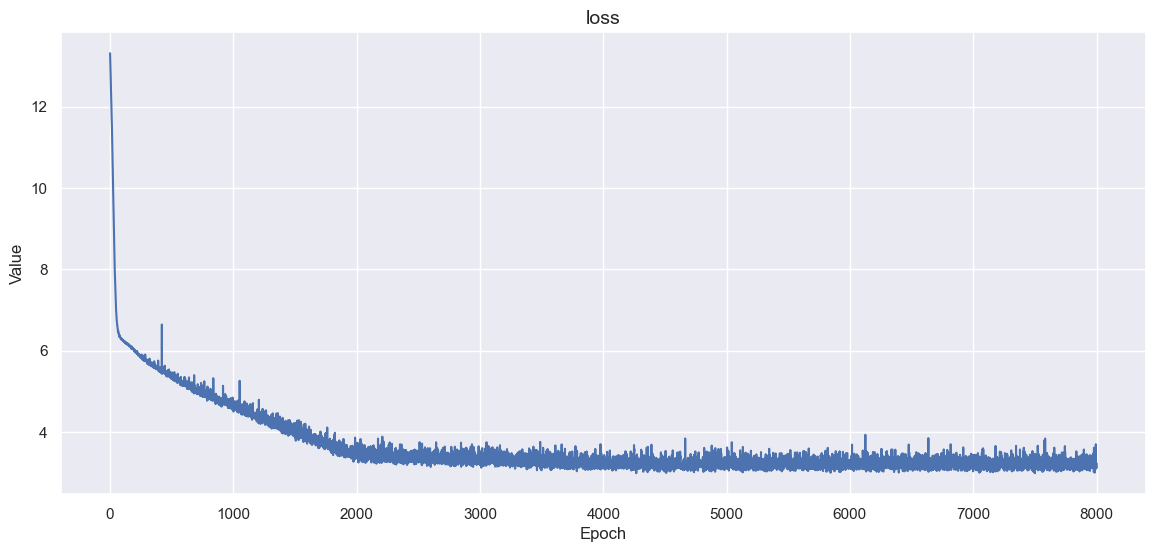

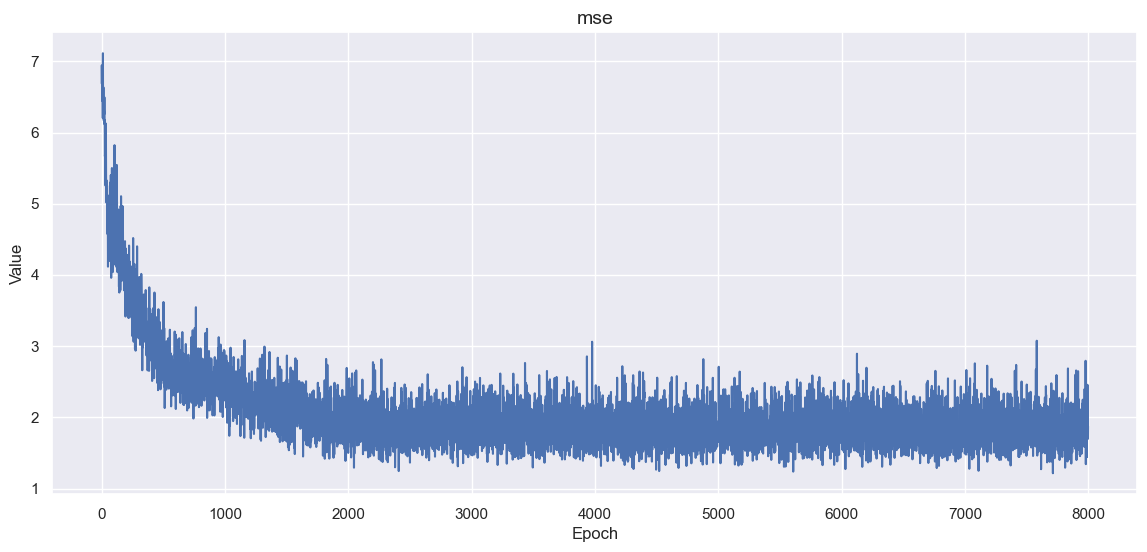

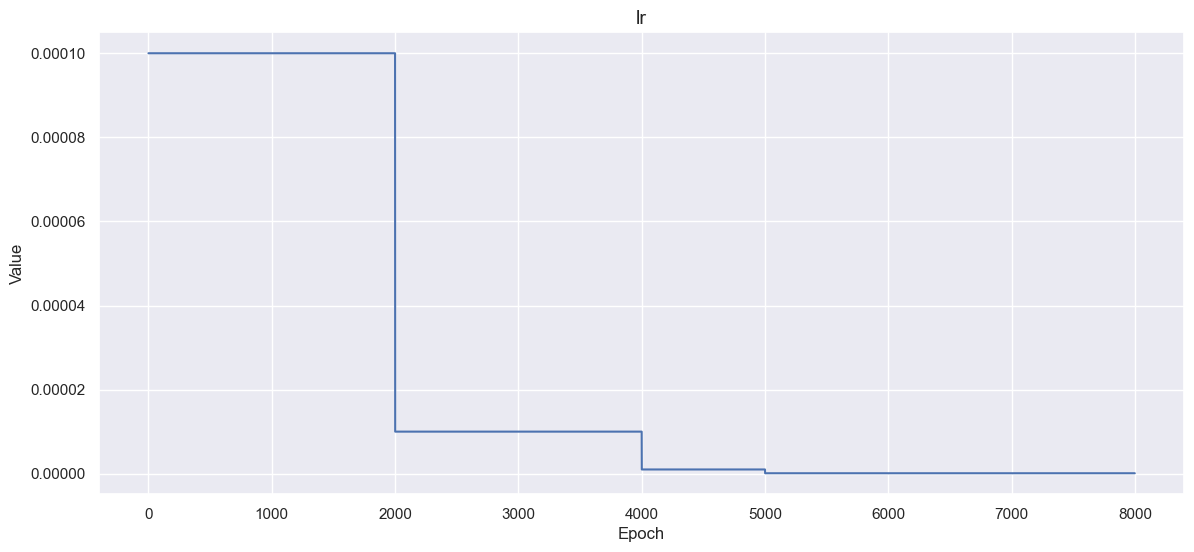

In [613]:
epochs = 8000

history_bayesian_vi = model_bayesian_vi.fit(
    x=x,
    y=y,
    epochs=epochs,
    callbacks=[NEpochsLogger(50), tf.keras.callbacks.LearningRateScheduler(lr_schedule)],
    verbose=0,
    batch_size=None
)

history_bayesian_vi_full = append_to_full_history(history_bayesian_vi, history_bayesian_vi_full)

plot_history(history_bayesian_vi_full)

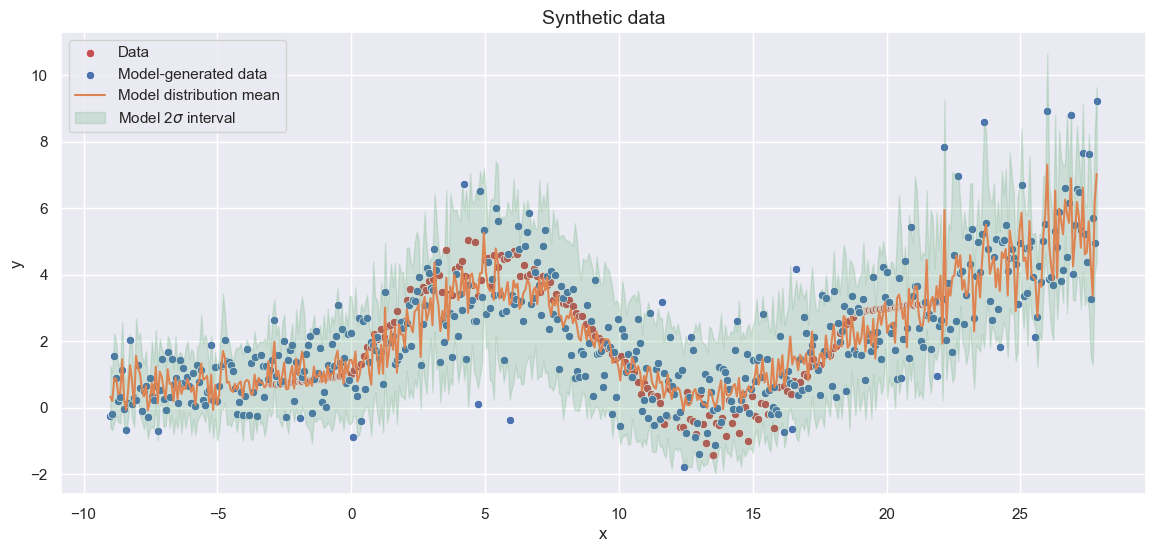

In [614]:
plot_prediction_distr(
    x,
    y,
    model_bayesian_vi,
    x_plot_min=x.numpy().min() - 6.,
    x_plot_max=x.numpy().max() + 6.
)

In [615]:
# model_bayesian_vi.save('../models/regression_review_bayesian_vi_model.tf')

# with open('../models/regression_review_bayesian_vi_model_history.pkl', 'wb') as f:
#     pickle.dump(history_bayesian_vi_full, f)

INFO:tensorflow:Assets written to: ../models/regression_review_bayesian_vi_model.tf/assets


INFO:tensorflow:Assets written to: ../models/regression_review_bayesian_vi_model.tf/assets


Observations:
- **Watch out for the scaling factor of the KL divergence** - TFP's documentation says normalize the divergence function for the Bayesian layers by a factor `1/batch_size` **if usign minibatch training - but irrespective of minibatches it the KL divergence term is not suppressed in the total loss (w.r.t. to the NLL one) the risk for the total loss to bounce back up after hitting a minimum, as well as that of getting null loss values, is high. Possible explanation: schematically, `total_loss = NLL + KLD`. Initially, if one term prevails over the other it will get minimized, at which point the other may prevail and lead the gradient descent towards regions of parameter space that in turns highly disfavour the first term, which comes back up. General rule: it's empirically safer if the NLL term prevails (it contains information about the data after all).
- In the Bayesian VI model, the means of the output distributions are not a smooth curve at all. Also, it's difficult to reproduce the the behaviour by which the (epistemic) uncertainty gets much bigger in regions in which we doing extrapolation.
- Note that the uncertainty of such a model is the combination of the epistemic and the aleatoric one.
- Keras uses a default batch size (equivalent to passing `batch_size=None` to the model's `fit` method) of 32. When a plateau of the loss is reached, it can help to increase tha batch size (maybe even increasing the learning rate at the same time!).

### Understanding the predictions from a Bayesian model

At each prediction, a full Bayesian probabilistic model samples two values (or sets thereof):
- A value for each parameter of the model (the Bayesian part). These parameters reflect on the parameters of the distribution outputted by the final layer.
- A value for the sample from the output distribution given by the parameters sampled in the point above.

Generate predictions for 2 points (2 values for $x$): for each point multiple output Gaussians are generated, each with a different mean and standard deviation. Each Gaussian is then sampled and a histogram per Gaussian is drawn.

Text(0.5, 1.0, 'Predictions for two points (means and distributions)')

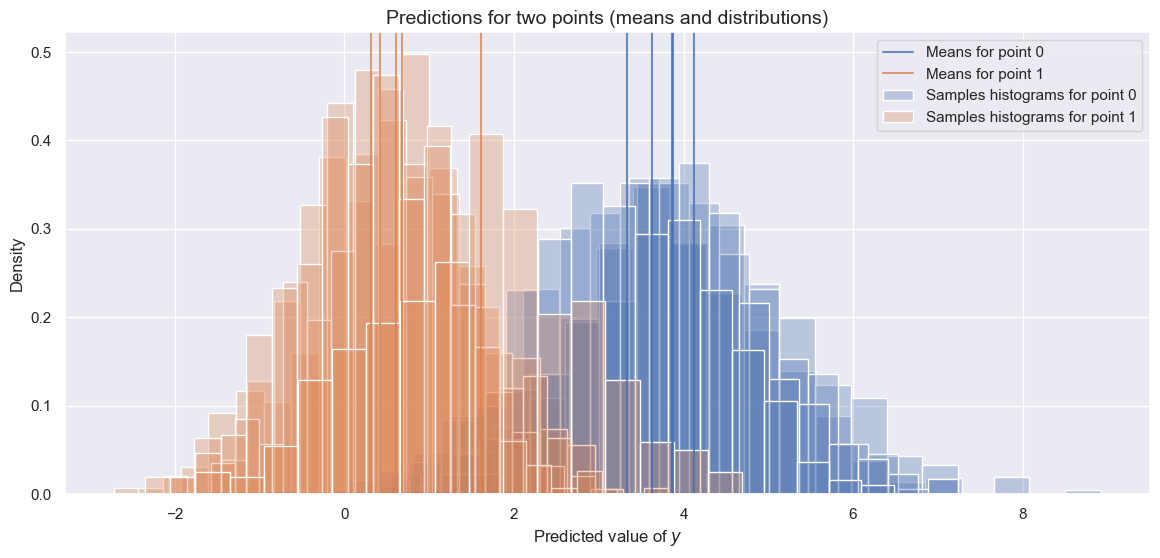

In [617]:
means, stdevs, samples = generate_predictions(model_bayesian_vi, [5., 12.])

fig = plt.figure(figsize=(14, 6))

# Loop over each point.
for i, point_index in enumerate(range(means.shape[1])):
    # x_point = points[point_index, 0]
    
    for j, mean_index in enumerate(range(means.shape[0])):
        mean = means[mean_index, point_index]
        
        sns.histplot(
            x=samples[mean_index, :, point_index],
            stat='density',
            alpha=.3,
            color=sns.color_palette()[i],
            label=f'Samples histograms for point {i}' if j == 0 else None
        )
    
        plt.axvline(
            x=[mean],
            alpha=.8,
            color=sns.color_palette()[i],
            label=f'Means for point {i}' if j == 0 else None
        )

plt.legend()
plt.xlabel('Predicted value of $y$')
plt.title('Predictions for two points (means and distributions)', fontsize=14)

Take a range of points, for each generate one output Gaussian and plot its mean.

Text(0.5, 1.0, 'Mean of one output Gaussian for each x')

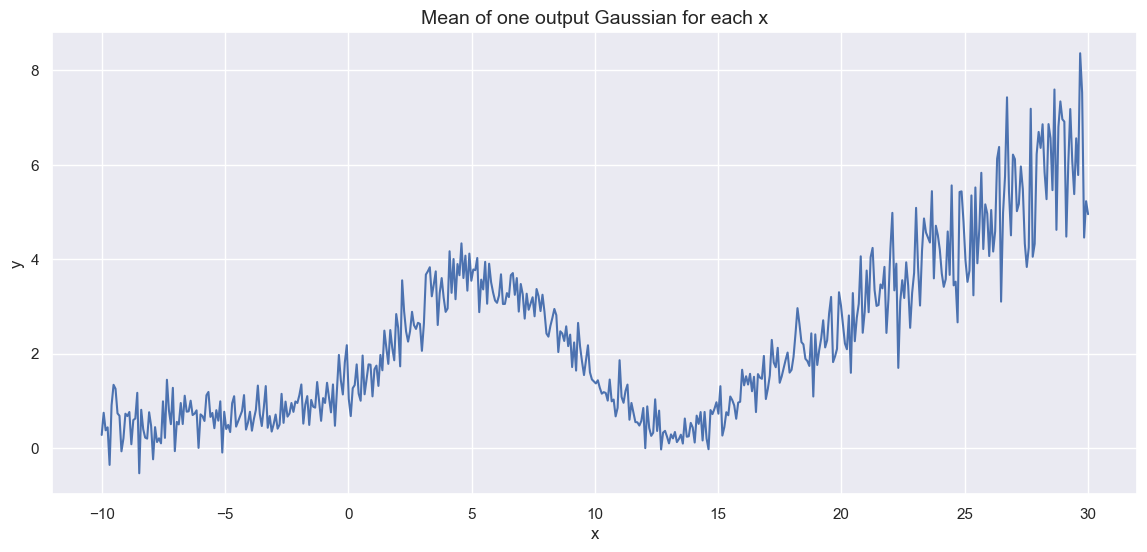

In [630]:
x_plot = tf.linspace(-10., 30., 500)

fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=x_plot,
    y=model_bayesian_vi(x_plot[:, tf.newaxis]).mean()[:, 0]
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Mean of one output Gaussian for each x', fontsize=14)

Take a set of 10 points along the $x$ axis and for each generate 20 output Gaussians. For each point plot the average mean +/+ the average standard deviation of the corresponding Gaussian.

In [689]:
x_interval = tf.linspace(-10., 30., 20)

means, stdevs, samples = generate_predictions(model_bayesian_vi, x_interval.numpy().tolist(), n_samples=None, n_distr=50)

average_means = tf.reduce_mean(means, axis=0)
stdev_means = tfp.stats.stddev(means)
average_stdevs = tf.reduce_mean(stdevs, axis=0)

Text(0.5, 1.0, 'Predictions (means)')

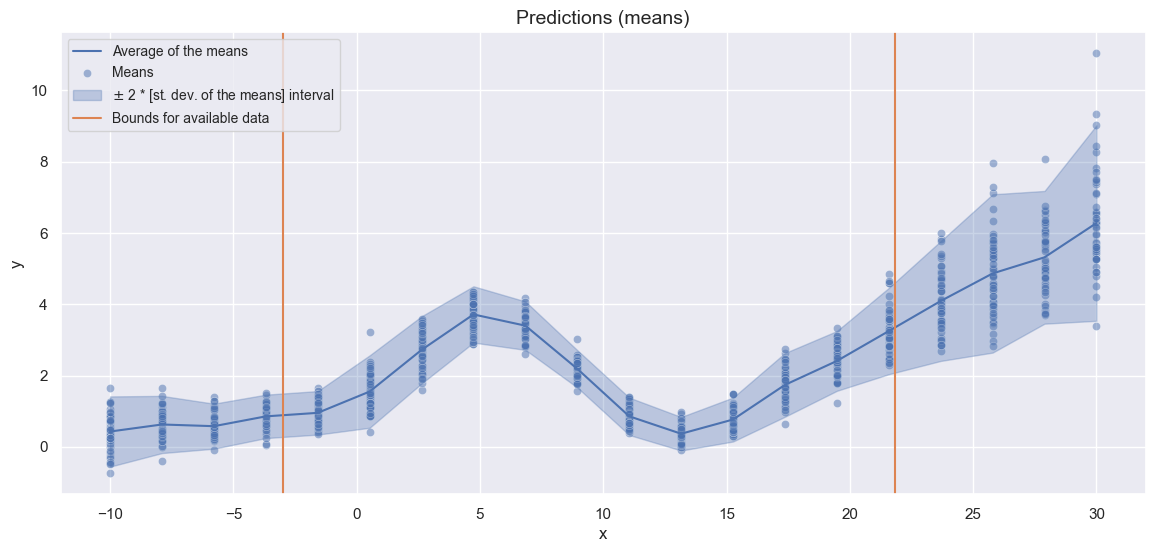

In [690]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=x_interval.numpy(),
    y=average_means,
    color=sns.color_palette()[0],
    label='Average of the means'
)

sns.scatterplot(
    x=tf.reshape(tf.constant([[x_position.numpy()] * means.shape[0] for x_position in x_interval]), x_interval.shape[0] * means.shape[0]).numpy(),
    y=tf.reshape(tf.transpose(means), means.shape[0] * means.shape[1]),
    color=sns.color_palette()[0],
    label='Means',
    alpha=.5
)

plt.fill_between(
    x=x_interval.numpy(),
    y1=average_means - 2. * stdev_means,
    y2=average_means + 2. * stdev_means,
    color=sns.color_palette()[0],
    alpha=.3,
    label='$\pm$ 2 * [st. dev. of the means] interval'
)

plt.axvline(
    x=x[:, 0].numpy().min(),
    label='Bounds for available data',
    color=sns.color_palette()[1],
)
plt.axvline(
    x=x[:, 0].numpy().max(),
    color=sns.color_palette()[1],
)

plt.legend(fontsize=10, loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predictions (means)', fontsize=14)

Observations:
- A sufficiently trained model willl get to a point in which a bigger undertainty is given to predictions in regions in which no training data was present.
- The right way to see the above point is by working with the means of the output Gaussians: for each point (value of x) generate multiple output Gaussians by running the inference step multiple times and taking the mean of the output distribution, then compute statistics of the means obtained this way. This way we'll be able to see that the distribution of the means for each point spreads out when we leave the region in which training data was present.

In [691]:
x_interval = tf.linspace(-10., 30., 20)

means, stdevs, samples = generate_predictions(model_bayesian_vi, x_interval.numpy().tolist(), n_samples=10, n_distr=50)

sample_means = tf.reduce_mean(
    tf.reshape(tf.transpose(samples, perm=[2, 0, 1]), (samples.shape[2], samples.shape[0] * samples.shape[1])),
    axis=1
)

sample_stdevs = tfp.stats.stddev(
    tf.reshape(tf.transpose(samples, perm=[2, 0, 1]), (samples.shape[2], samples.shape[0] * samples.shape[1])),
    sample_axis=1
)

Text(0.5, 1.0, 'Predictions (samples)')

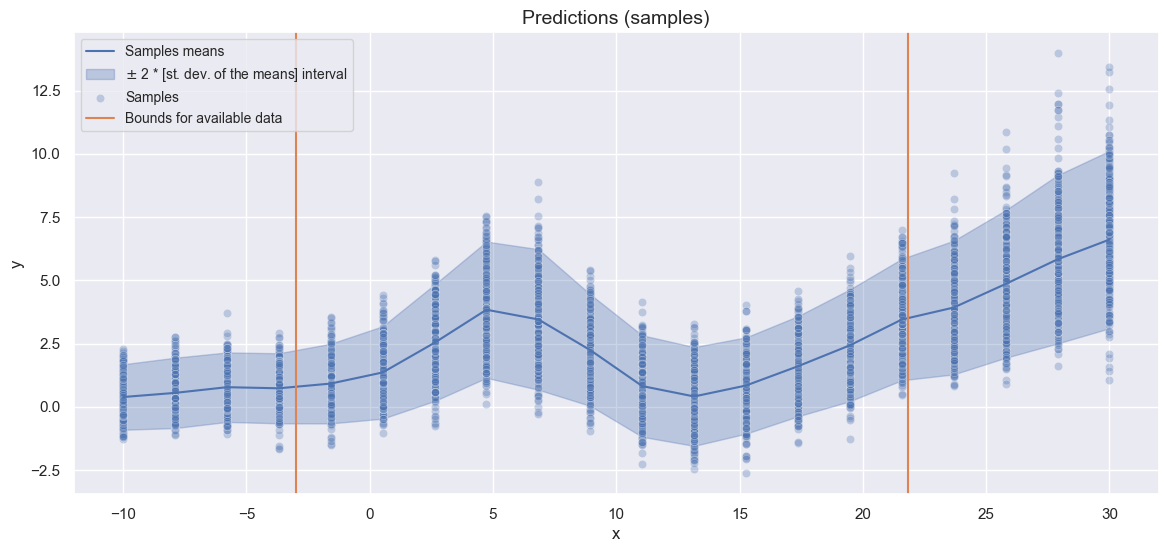

In [692]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    x=x_interval.numpy(),
    y=sample_means,
    color=sns.color_palette()[0],
    label='Samples means'
)

plt.fill_between(
    x=x_interval.numpy(),
    y1=sample_means - 2. * sample_stdevs,
    y2=sample_means + 2. * sample_stdevs,
    color=sns.color_palette()[0],
    alpha=.3,
    label='$\pm$ 2 * [st. dev. of the means] interval'
)

sns.scatterplot(
    x=tf.reshape(tf.constant([[x_position.numpy()] * (samples.shape[0] * samples.shape[1]) for x_position in x_interval]), x_interval.shape[0] * samples.shape[0] * samples.shape[1]).numpy(),
    y=tf.reshape(tf.transpose(samples, perm=[2, 0, 1]), samples.shape[0] * samples.shape[1] * samples.shape[2]),
    color=sns.color_palette()[0],
    label='Samples',
    alpha=.3
)

plt.axvline(
    x=x[:, 0].numpy().min(),
    label='Bounds for available data',
    color=sns.color_palette()[1],
)
plt.axvline(
    x=x[:, 0].numpy().max(),
    color=sns.color_palette()[1],
)

plt.legend(fontsize=10, loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predictions (samples)', fontsize=14)